# Traffic on highway - regression model

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Handling the data
import pandas as pd
import numpy as np
import datetime

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Statistics
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew

# Other
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import cross_val_score
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error 

Your task is to apply various ML algorithms (see the rules below) to build a model **explaining the traffic** on one of the highways for one-hourly intervals based on the **training sample** and generate predictions for **all observations** from the **test sample**.

The dataset includes the following columns:

* *date_time* – date and time (1 hourly interval)
* *weather_general* – general short description of the current weather with the following levels: Clear, Clouds, Drizzle, Fog, Haze, Mist, Rain, Smoke, Snow, Squall, Thunderstorm
* *weather_detailed* – more detailed description of the current weather with the following levels: broken clouds, drizzle, few clouds, fog, freezing rain, haze, heavy intensity drizzle, heavy intensity rain, heavy snow, light intensity drizzle, light intensity shower rain, light rain, light rain and snow, light shower snow, light snow, mist, moderate rain, overcast clouds, proximity shower rain, proximity thunderstorm, proximity thunderstorm with drizzle, proximity thunderstorm with rain, scattered clouds, shower drizzle, shower snow, sky is clear, sleet, smoke, snow, squalls, thunderstorm, thunderstorm with drizzle, thunderstorm with heavy rain, thunderstorm with light drizzle, thunderstorm with light rain, thunderstorm with rain, very heavy rain
* *clouds_coverage* – percentage of sky covered by the clouds in the hourly interval
* *temperature* – average temperature in the hourly interval (in Celsius degrees)
* *rain_mm* – amount of rain that occurred in the hourly interval (in mm)
* *snow_mm* – amount of snow that occurred in the hourly interval (in mm)
* *traffic* – the amount of traffic in the hourly interval (outcome variable, only in the training sample)

## 1. Import and understand the data

In [2]:
train_org = pd.read_csv("traffic_train.csv")
test_org = pd.read_csv("traffic_test.csv")

train = train_org.copy()
test = test_org.copy()

display(train.head())

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
0,2014-10-01 00:00:00,Clear,sky is clear,1,11.5,0.0,0.0,508
1,2014-10-01 01:00:00,Clear,sky is clear,1,10.3,0.0,0.0,323
2,2014-10-01 02:00:00,Clear,sky is clear,1,8.0,0.0,0.0,274
3,2014-10-01 03:00:00,Clear,sky is clear,1,7.9,0.0,0.0,372
4,2014-10-01 04:00:00,Clear,sky is clear,1,6.4,0.0,0.0,812


In [3]:
display(train.sample())

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
25795,2018-08-16 00:00:00,Clear,sky is clear,0,19.6,0.0,0.0,618


In [4]:
display(test.head())

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm
0,2019-01-01 00:00:00,Mist,mist,90,-0.2,0,0
1,2019-01-01 00:00:00,Haze,haze,90,-0.2,0,0
2,2019-01-01 00:00:00,Snow,light snow,90,-0.2,0,0
3,2019-01-01 00:00:00,Drizzle,light intensity drizzle,90,-0.2,0,0
4,2019-01-01 01:00:00,Mist,mist,90,-0.2,0,0


In [5]:
print(train.shape, test.shape)

(29701, 8) (10591, 7)


In [6]:
test["traffic"] = float("NAN")
data_org = pd.concat((train.loc[:,'date_time':'traffic'],
                  test.loc[:,'date_time':'traffic']))
data = data_org.copy()

### 1.1. Numerical data

My goal is to predict the amount of traffic in the hourly interval, where **traffic** is my target variable.

In [7]:
train.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
count,29701.000000,29701.000000,29701.000000,29701.000000,29701.000000
mean,50.210027,7.500451,0.509914,0.000361,3228.196761
std,38.657342,13.769115,57.058322,0.010403,1989.059081
min,0.000000,-273.100000,0.000000,0.000000,0.000000
25%,1.000000,-1.300000,0.000000,0.000000,1159.000000
50%,64.000000,8.300000,0.000000,0.000000,3309.000000
75%,90.000000,18.300000,0.000000,0.000000,4918.000000
max,100.000000,35.100000,9831.300000,0.510000,7263.000000


In [8]:
data.describe()

,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
count,40292.000000,40292.000000,40292.000000,40292.000000,29701.000000
mean,50.091085,7.695778,0.375880,0.000266,3228.196761
std,38.892797,13.257272,48.988908,0.008933,1989.059081
min,0.000000,-273.100000,0.000000,0.000000,0.000000
25%,1.000000,-0.900000,0.000000,0.000000,1159.000000
50%,64.000000,8.600000,0.000000,0.000000,3309.000000
75%,90.000000,18.100000,0.000000,0.000000,4918.000000
max,100.000000,35.100000,9831.300000,0.510000,7263.000000


In case of numerical variables, there are no any missing values and there is no a huge difference between all the data and training dataset. 
- clouds_coverage_pct is calculated in percentage scale
- temperature of -273 as a minimum, this should definitely be checked. Max 35 I can believe
- rain_mm, also an interesting situation that it rained 9831 in mm, it is worth looking into if it makes sense (1825 over the whole day is the World record and 401 over the hour)
- it snows relatively little
- traffic can surprisingly even be 0, quite important because in case of a transformation of a variable, you have to use the logarithm of log(1+x)


In the case of the test dataset, we have values of 0, which is incorrect because we will be using the MAPE metric. We need to remove such values from the training and test datasets.

In the next step, let's see how the traffic looks liked depending on numerical features.

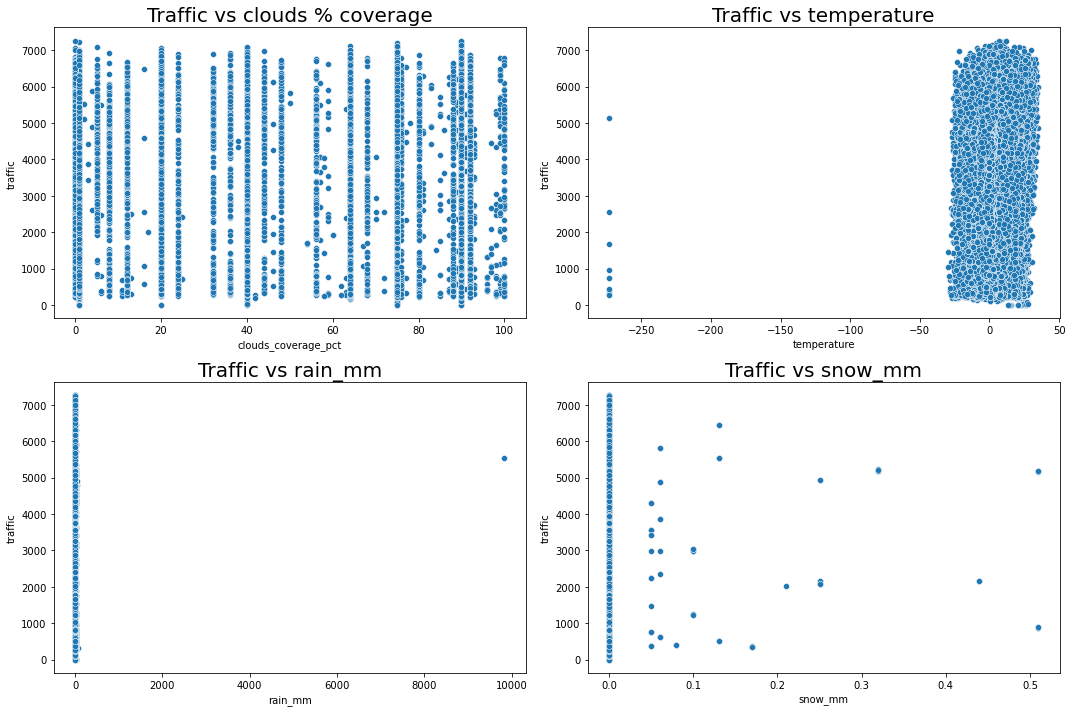

In [9]:
numerical_features = train.loc[:, "clouds_coverage_pct":"snow_mm"].columns

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10), sharey = False)

sns.scatterplot(x = train.clouds_coverage_pct, y = train.traffic, ax = axs[0,0])
axs[0,0].set_title("Traffic vs clouds % coverage", fontsize = 20)

sns.scatterplot(x = train.temperature, y = train.traffic, ax = axs[0,1])
axs[0,1].set_title("Traffic vs temperature", fontsize = 20)

sns.scatterplot(x = train.rain_mm, y = train.traffic, ax = axs[1,0])
axs[1,0].set_title("Traffic vs rain_mm", fontsize = 20)

sns.scatterplot(x = train.snow_mm, y = train.traffic, ax = axs[1,1])
axs[1,1].set_title("Traffic vs snow_mm", fontsize = 20)

fig.tight_layout()
plt.show()

With high probability, this dataset contains outliers, which only confirms my earlier guess. I will certainly have to look more closely at columns such as temperature, rain_mm and snow_mm. 

### 1.2. Characteric data

Let's check how the data looks like in division into years and month.

In [10]:
data["date_time"]= pd.to_datetime(data["date_time"])

yearly_monthly_traffic = pd.DataFrame({"date_time": data["date_time"],
                                       "Year": data["date_time"].dt.year,
                                       "Month": data["date_time"].dt.month,
                                       "Day_no": data["date_time"].dt.day,
                                       "Hour": data["date_time"].dt.hour,
                                       "Day": data["date_time"].dt.strftime("%A"),
                                        "Traffic": data["traffic"]})

In [11]:
yearly_monthly_traffic.head()

,date_time,Year,Month,Day_no,Hour,Day,Traffic
0,2014-10-01 00:00:00,2014,10,1,0,Wednesday,508.0
1,2014-10-01 01:00:00,2014,10,1,1,Wednesday,323.0
2,2014-10-01 02:00:00,2014,10,1,2,Wednesday,274.0
3,2014-10-01 03:00:00,2014,10,1,3,Wednesday,372.0
4,2014-10-01 04:00:00,2014,10,1,4,Wednesday,812.0


In [12]:
yearly_monthly_traffic.groupby("Year")["Traffic"].agg(["mean", "median", "max", "min"]).T

Year,2014,2015,2016,2017,2018,2019
mean,3189.193834,3286.904389,3258.02878,3229.878815,3168.964707,NaN
median,3161.000000,3344.500000,3331.00000,3347.000000,3261.000000,NaN
max,7192.000000,7217.000000,7086.00000,6890.000000,7263.000000,NaN
min,129.000000,165.000000,191.00000,0.000000,0.000000,NaN


Year variable seems to be useless. Most probably I will reduce it.

In [13]:
yearly_monthly_traffic.groupby("Month")["Traffic"].agg(["mean", "median", "max", "min"]).T

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,3092.853853,3175.934211,3287.63456,3363.367148,3348.285343,3421.16126,3185.316165,3357.932528,3219.361826,3389.032877,3108.90234,2928.724572
median,3116.500000,3229.500000,3465.50000,3477.500000,3404.000000,3559.00000,3230.000000,3569.000000,3345.000000,3771.000000,3074.00000,2867.000000
max,6942.000000,7119.000000,7086.00000,7263.000000,7125.000000,6919.00000,7086.000000,7018.000000,6857.000000,7092.000000,7192.00000,7055.000000
min,191.000000,206.000000,208.00000,122.000000,211.000000,247.00000,0.000000,0.000000,0.000000,212.000000,198.00000,103.000000


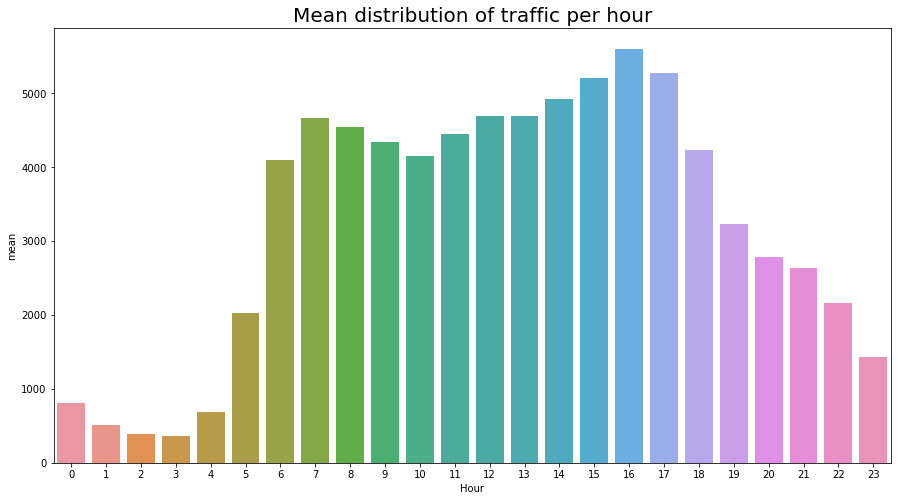

In [14]:
traffic_hourly = yearly_monthly_traffic.groupby("Hour")["Traffic"].agg(["mean", "median", "max", "min"])

plt.subplots(figsize = (15,8))
sns.barplot(x = traffic_hourly.index, y = 'mean', data = traffic_hourly).set_title('Mean distribution of traffic per hour', fontsize = 20)
plt.show()


In the dataset, there are no any jumps in value, so either every year and month are definitely comparable. When it comes to hours, there is rationality in the data, which is definitely satysfaing. This knowledge, will definitely help me to somehow divide the **date_time** variable.

In [15]:
data["weather_general"].value_counts()

Clouds          13163
Clear           11091
Mist             4855
Rain             4680
Snow             2363
Drizzle          1543
Haze             1089
Thunderstorm      766
Fog               720
Smoke              18
Squall              4
Name: weather_general, dtype: int64

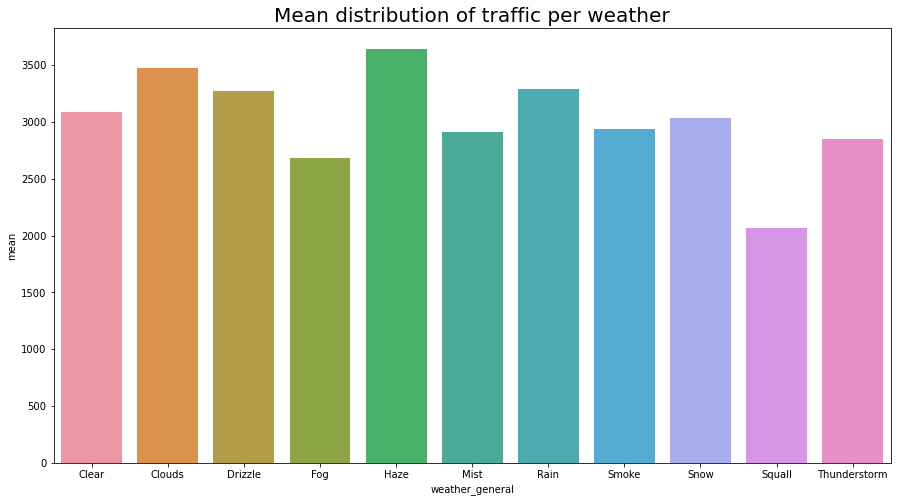

In [16]:
weather_traffic = data.groupby("weather_general")["traffic"].agg(["mean", "median", "max", "min"])

plt.subplots(figsize = (15,8))
sns.barplot(x = weather_traffic.index, y = 'mean', data = weather_traffic).set_title('Mean distribution of traffic per weather', fontsize = 20)
plt.show()

Mist and Fog are the same occurance, I can also add into it a smoke and haze. Squall is like thunderstorm. Definitely worth to bucket it somehow.

In [17]:
data["weather_detailed"].value_counts()

sky is clear                           11091
mist                                    4855
overcast clouds                         4529
broken clouds                           4011
scattered clouds                        2896
light rain                              2824
few clouds                              1727
light snow                              1539
moderate rain                           1344
haze                                    1089
light intensity drizzle                  908
fog                                      720
heavy snow                               588
drizzle                                  576
proximity thunderstorm                   490
heavy intensity rain                     387
snow                                     219
proximity shower rain                     94
thunderstorm                              88
heavy intensity drizzle                   57
thunderstorm with heavy rain              56
thunderstorm with light rain              41
proximity 

I think that this variable, doesn't give me any additional information. Most probably, I will remove it.

In [18]:
# Checking missing values in characteric data
data[["date_time", "weather_general", "weather_detailed"]].isna().sum()

date_time           0
weather_general     0
weather_detailed    0
dtype: int64

### 1.3. Duplicates

As the data concerns only one highway, we should assume that the detection point for one hour should occur once. Otherwise, this would be an incorrect implementation of the measurement time. I will check, therefore, whether such a situation actually occurs.

In [19]:
def show_duplicates(dataset):
    
    temp = dataset["date_time"].duplicated()
    print("Sum of duplicates is equal to: {}\n" \
          "Percentage of duplicates is equal to: {:.4}%.".format(temp.sum(), 100 * (temp.sum()/len(data))))
    
    print('' * 30)
    
    print("Summary of duplicates")
    print(dataset[temp]["date_time"].value_counts().value_counts())
                      
show_duplicates(train)

Sum of duplicates is equal to: 4339
Percentage of duplicates is equal to: 10.77%.

Summary of duplicates
1    2037
2     825
3     174
4      30
5       2
Name: date_time, dtype: int64


There are a lot of duplicated values in the whole dataset, however let me check, if the same situation is applied to test dataset.

In [20]:
show_duplicates(test)

Sum of duplicates is equal to: 1878
Percentage of duplicates is equal to: 4.661%.

Summary of duplicates
1    887
2    400
3     61
4      2
Name: date_time, dtype: int64


As above, we can see that this situation also occurs in test dataset. That's why I shouldn't remove duplicated records.
Nevertheless below, let's see some the most duplicated records in order to assess, if there are significant differences between measurements.

In [21]:
def show_duplicated_values_df():
    
    temp = data.copy() 
    temp["Count"] = 1
    check_dup = temp.groupby('date_time').Count.count().reset_index().sort_values("Count", ascending = False)
    check_dup['Count'] = check_dup['Count'] - 1 # Get pure duplicates
    check_dup["date_time"][:2]
    result = data[data["date_time"].isin(check_dup["date_time"][:2])] # Check only for 5 duplicates
    return result

show_duplicated_values_df()

,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic
5234,2015-04-16 22:00:00,Mist,mist,90,1.6,0.0,0.0,1535.0
5235,2015-04-16 22:00:00,Drizzle,light intensity drizzle,90,1.6,0.0,0.0,1531.0
5236,2015-04-16 22:00:00,Rain,light rain,90,1.6,0.0,0.0,1534.0
5237,2015-04-16 22:00:00,Rain,moderate rain,90,1.6,0.0,0.0,1535.0
5238,2015-04-16 22:00:00,Snow,heavy snow,90,1.6,0.0,0.0,1537.0
5239,2015-04-16 22:00:00,Snow,snow,90,1.6,0.0,0.0,1534.0
6147,2015-05-17 10:00:00,Thunderstorm,thunderstorm with light rain,90,14.0,0.0,0.0,3586.0
6148,2015-05-17 10:00:00,Mist,mist,90,14.0,0.0,0.0,3589.0
6149,2015-05-17 10:00:00,Thunderstorm,proximity thunderstorm,90,14.0,0.0,0.0,3595.0
6150,2015-05-17 10:00:00,Rain,moderate rain,90,14.0,0.0,0.0,3597.0


We can see that for some dates, the measurements occurred up to 6 times. I cannot accept this as correct data. The only consolation is that the values for traffic are not highly variable for the times given. However, what if e.g. during the first measurement the sun was shining and during the second one we had a downpour?


## 2. Preparation of the data

### 2.1. Target variable - traffic

Let's check the distribution of dependent variable - target.

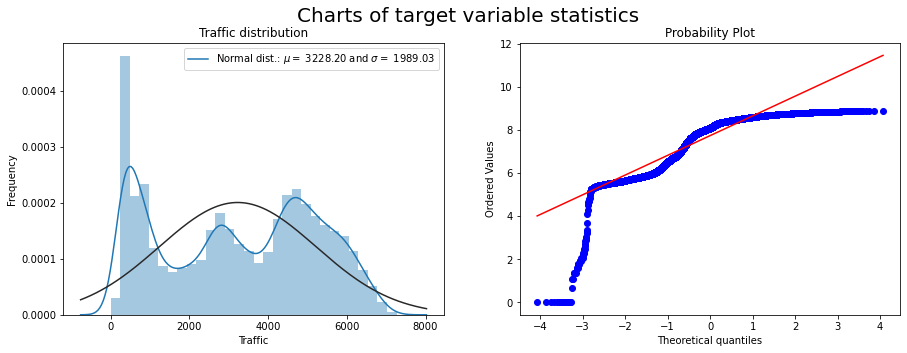

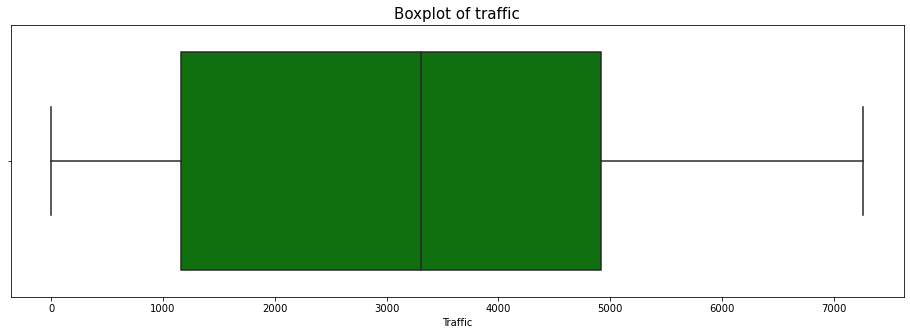

In [22]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5), sharey = False)
fig.suptitle("Charts of target variable statistics", fontsize = 20)

sns.distplot(data['traffic'], ax=axs[0], fit=norm)

# Get the fitted parameters used by the function
mu, sigma = norm.fit(data['traffic'].dropna())

axs[0].legend(['Normal dist.: $\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc='best')
axs[0].set_xlabel('Traffic')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Traffic distribution')

#Get also the QQ-plot
axs[1] = stats.probplot(np.log1p(data['traffic']).dropna(), plot=plt)
plt.show()

plt.subplots(figsize = (16,5))
traffic_boxplot = sns.boxplot(data['traffic'], color = "green")
traffic_boxplot.set_title("Boxplot of traffic", fontsize = 15)
traffic_boxplot.set_xlabel("Traffic", fontsize = 10)

plt.show()

In [23]:
print("Skewness is equal to: %f" % data['traffic'].skew())
print("Kurtosis is equal to: %f" % data['traffic'].kurt())

Skewness is equal to: -0.063597
Kurtosis is equal to: -1.315145


Unluckily, the target variable looks to be bimodal, unsymmetric - it might have a huge impact on my future prediction. In this case, it seems to me that it is nearly impossible to transform it in such a way, that it will resemble to normal distribution. 

#### 2.1.1. Remove 0 traffic values

Because of the fact, that I will be calculating MAPE score, I need to be sure that there are no 0 values in my target variable. Let's remove that "problematic records".

In [24]:
data.drop(data[data.traffic == 0].index, inplace = True)

sum(data.traffic == 0)

0

#### 2.1.2. Correlations

<AxesSubplot:>

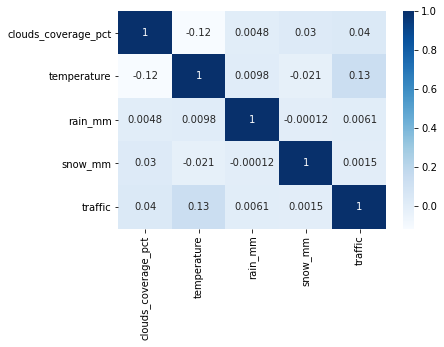

In [25]:
corr = data.corr(method = "pearson")
sns.heatmap(corr, cmap="Blues", annot=True)

There is no high correlation between my target variable and other variables which is good.

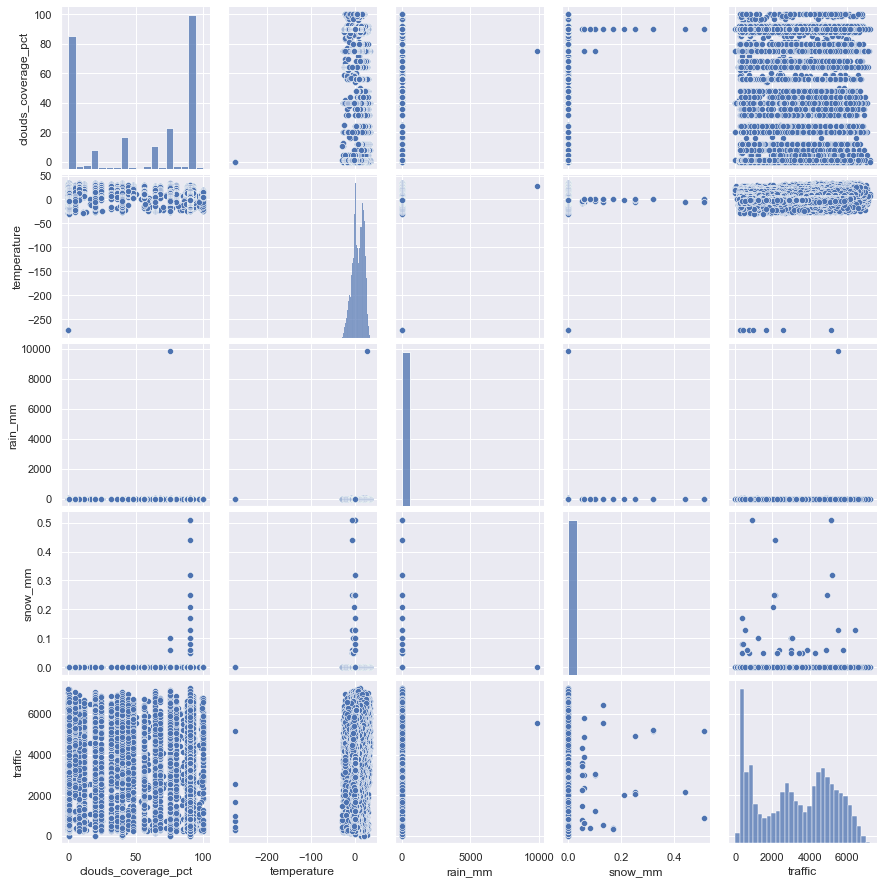

In [26]:
sns.set()
cols = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm', 'traffic']
sns.pairplot(train[cols], size = 2.5)
plt.show()

As I previously wrote and the above graph only ensured me. In the dataset there a lot of outliers.

### 2.2. Numerical independent variables

#### 2.2.1 Outliers

Definitely there is lack of normality of the variables, however let me check z-scores of my data in order to verify that there are no outliers and calculate records which values are higher than 3.

In [27]:
def check_outliers_zscore(your_data, numerical_columns):
    
    temp = your_data.copy()
    outliers_idx = []
    
    for ncol in numerical_columns:
    
        temp_series = pd.Series(stats.zscore(temp[ncol]), name = ncol+'_zscore')
        temp = pd.concat([temp, temp_series], axis = 1)
        outlier_list_col = temp[(abs(temp[ncol]) > 3)].index
        outliers_idx.extend(outlier_list_col)
        
    return len(np.unique(outliers_idx))

numerical_columns = ['clouds_coverage_pct', 'temperature', 'rain_mm', 'snow_mm']
check_outliers_zscore(train, numerical_columns)

28842

In [28]:
grouping_by_weather = data.groupby("weather_general")["clouds_coverage_pct"].mean()
data = data.reset_index()
data = data.merge(grouping_by_weather, on = "weather_general")
data.rename(columns = {"clouds_coverage_pct_x": "clouds_coverage_pct"}, inplace=True)
data.rename(columns = {"clouds_coverage_pct_y": "clouds_coverage_mean_grouped"}, inplace=True)
# data.drop("index", axis = 1, inplace = True)

In [29]:
data[data.traffic.isna()]

,index,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,clouds_coverage_mean_grouped
8025,22,2019-01-01 15:00:00,Clear,sky is clear,1,-11.9,0.0,0.0,NaN,1.515154
8026,23,2019-01-01 16:00:00,Clear,sky is clear,1,-12.1,0.0,0.0,NaN,1.515154
8027,24,2019-01-01 17:00:00,Clear,sky is clear,1,-12.7,0.0,0.0,NaN,1.515154
8028,25,2019-01-01 18:00:00,Clear,sky is clear,5,-13.5,0.0,0.0,NaN,1.515154
8029,26,2019-01-01 19:00:00,Clear,sky is clear,5,-14.1,0.0,0.0,NaN,1.515154
...,...,...,...,...,...,...,...,...,...,...
40250,10587,2019-12-31 20:00:00,Snow,light snow,90,-9.9,0.0,0.0,NaN,81.667795
40251,10588,2019-12-31 21:00:00,Snow,light snow,90,-9.6,0.0,0.0,NaN,81.667795
40252,10589,2019-12-31 22:00:00,Snow,light snow,90,-10.2,0.0,0.0,NaN,81.667795
40253,10590,2019-12-31 23:00:00,Snow,light snow,90,-10.7,0.0,0.0,NaN,81.667795


There are a lot of observations, which might be our potential outliers. Nevertheless, I think that most of them comes from variable *clouds_coverage_pct* and *temperature*. Now I will dive deeper into the data and try to reduce the impact of outliers.

##### Temperature

In [30]:
data[data["temperature"] < -30] 

,index,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,clouds_coverage_mean_grouped
2705,11883,2016-01-29 03:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,358.0,1.515154
2706,11884,2016-01-29 04:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,734.0,1.515154
2707,11885,2016-01-29 05:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,2561.0,1.515154
2708,11886,2016-01-29 06:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,5148.0,1.515154
2748,11931,2016-01-31 03:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,292.0,1.515154
2749,11932,2016-01-31 04:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,286.0,1.515154
2750,11933,2016-01-31 05:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,437.0,1.515154
2751,11934,2016-01-31 06:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,740.0,1.515154
2752,11935,2016-01-31 07:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,960.0,1.515154
2753,11936,2016-01-31 08:00:00,Clear,sky is clear,0,-273.1,0.0,0.0,1674.0,1.515154


As we see above, something is definitely not good. Let's get rid of these records.

In [31]:
data.drop(data[data.temperature < -30].index, inplace = True)

##### Rain_mm

World record of rain in one hour is equal to 401. Let's look for higher values and if they exist, delete them.

In [32]:
data[data["rain_mm"] > 100]

,index,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,clouds_coverage_mean_grouped
27173,24857,2018-07-09 17:00:00,Rain,very heavy rain,75,29.0,9831.3,0.0,5531.0,74.291364


As before, some kind of wrong number.

In [33]:
data.drop(data[data.rain_mm > 100].index, inplace = True)

##### Snow_mm

Let's check snow, because I think that, my highway comes from rather hot climate.

In [34]:
data[data["snow_mm"] > np.quantile(data["snow_mm"], 0.99)] # higher than std

,index,date_time,weather_general,weather_detailed,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,clouds_coverage_mean_grouped
26621,20143,2017-12-20 12:00:00,Rain,moderate rain,90,1.2,0.98,0.51,5171.0,74.291364
26622,20149,2017-12-20 14:00:00,Rain,moderate rain,90,0.6,0.00,0.32,5179.0,74.291364
26626,20474,2018-01-05 00:00:00,Rain,light rain,75,0.2,0.00,0.06,627.0,74.291364
26627,20477,2018-01-05 01:00:00,Rain,light rain,90,0.1,0.00,0.17,358.0,74.291364
32832,20145,2017-12-20 12:00:00,Mist,mist,90,1.2,0.98,0.51,5170.0,67.714256
...,...,...,...,...,...,...,...,...,...,...
38999,20471,2018-01-05 00:00:00,Snow,snow,75,0.2,0.00,0.06,627.0,81.667795
39000,20475,2018-01-05 01:00:00,Snow,light snow,90,0.1,0.00,0.17,366.0,81.667795
39001,20478,2018-01-05 03:00:00,Snow,light snow,90,0.1,0.00,0.08,396.0,81.667795
39008,20492,2018-01-05 13:00:00,Snow,light snow,90,0.7,0.00,0.25,4932.0,81.667795


Let's also check the snowing rate for the whole dataset.

In [35]:
sum(data.snow_mm > 0)/len(data)

0.001564634297777226

In case of snow, we see that very little, if any, snow has fallen. Therefore, in this case, I have decided not to change anything. 

Having managed to remove the observations that I am sure are wrong, let's think about what can be done with the remaining observations that could have a significant impact on the potential results. In particular, I will be interested in the columns on clouds_coverage_percentage and temperature. They seem to be important.

In [36]:
numerical_features = ['clouds_coverage_pct', 'temperature']
def check_outliers_zscore(temp, features):
    
    outliers_idx = []
    iterator = 0
    for col in features:
        iterator = 0
        Q_lower = np.quantile(temp[col], 0.05)
        Q_higher = np.quantile(temp[col], 0.95)

        # outlier step
        outlier_list_col = temp[(temp[col] < Q_lower) | (temp[col] > Q_higher)].index
        print(f"Number of possible outliers in column {col} is equal to {len(outlier_list_col)}")
        print("")
        temp[col].values[temp[col].values > Q_higher] = Q_higher
        temp[col].values[temp[col].values < Q_lower] = Q_lower
        
    print("Outliers are successfully changed!")

check_outliers_zscore(data, numerical_features)

Number of possible outliers in column clouds_coverage_pct is equal to 2964

Number of possible outliers in column temperature is equal to 3993

Outliers are successfully changed!


### 2.3. Characterical independent variables

#### 2.3.1. Date_time

I will create 6 new variables: Year, Month, Day number(Day_no), Hour, Day (e.g. Monday) and quarter. 

In [37]:
yearly_monthly_traffic.drop_duplicates(subset=['date_time'], keep='last', inplace = True)
data = data.merge(yearly_monthly_traffic[["date_time", "Year", "Month", "Day_no", "Hour", "Day"]], on = "date_time", how = "left")
data['quarter'] = pd.to_datetime(data.date_time).dt.quarter
data.drop('date_time', axis = 1, inplace = True)

#### 2.3.2. Weather_detailed

This variable does not add any new significant value. Furthermore, there are certainly cases where the values from *weather_detailed* differ from those from *weather_general*. Variable *weather_detailed* has been droppped.

In [38]:
data.drop("weather_detailed", axis=1, inplace = True)

#### 2.3.3. Weather_general

In the case of the w*eather_general* variable, I think it's better to make it more generic, as some of the naming is really the same thing.

In [39]:
data.replace({'weather_general' : {'Fog': "Mist", 
                                    "Haze": "Mist", 
                                    "Smoke": "Mist", 
                                    'Squall' : "Thunderstorm"}}, inplace = True)

#### 2.3.4 Additional new features

Now, we are one step before encoding our characteric data. That's why, I will also create new variable which defines whether the day is a working day or not. I expect that at weekends the streets are much less congested.

In [40]:
data["working_days"] = data.Day_no.apply(lambda x: 1 if x != 'Saturday' and x != 'Sunday' else 0)

#### 2.3.4. Dummy encoding

Because, there is no ordinal data, I will only use dummy encoding with dropping one level of each characteric variable.

In [41]:
data = pd.get_dummies(data, drop_first = True)
data.head()

,index,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,clouds_coverage_mean_grouped,Year,Month,Day_no,...,weather_general_Mist,weather_general_Rain,weather_general_Snow,weather_general_Thunderstorm,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,0,1,11.5,0.0,0.0,508.0,1.515154,2014,10,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,10.3,0.0,0.0,323.0,1.515154,2014,10,1,...,0,0,0,0,0,0,0,0,0,1
2,2,1,8.0,0.0,0.0,274.0,1.515154,2014,10,1,...,0,0,0,0,0,0,0,0,0,1
3,3,1,7.9,0.0,0.0,372.0,1.515154,2014,10,1,...,0,0,0,0,0,0,0,0,0,1
4,4,1,6.4,0.0,0.0,812.0,1.515154,2014,10,1,...,0,0,0,0,0,0,0,0,0,1


### 2.4. Data transformation and creation of new variables

At first let's create new variables which may have a positive impact on my future predictions. In my opinion, variables *temperature* and those connected with time - especially *Hour* and *Month* seems to be the most important one. It is within these variables that I will seek to create new relationships.

I will create binary variable assessing if traffic occurence was during working hours.

In [42]:
data["working_hours"] = data.Hour.apply(lambda x: 1 if x>=6 and x<=19 else 0)

In the below codes, I will create a new range of variables which are directly link to traffic output which are both dependent from temperature and time. 

In [43]:
mean_temperature = data[~data.traffic.isna()].groupby("Month")["temperature"].agg(["mean"])
data = pd.merge(data, mean_temperature, on = "Month", how = "left")
data.rename(columns = {"mean": "mean_temperature_monthly"}, inplace=True)


mean_traffic_monthly = data[~data.traffic.isna()].groupby("Month")["traffic"].agg(["mean"])
data = pd.merge(data, mean_traffic_monthly, on = "Month", how = "left")
data.rename(columns = {"mean": "mean_traffic_monthly"}, inplace=True)


mean_traffic_hourly = data[~data.traffic.isna()].groupby("Hour")["traffic"].agg(["mean"])
data = pd.merge(data, mean_traffic_hourly, on = "Hour", how = "left")
data.rename(columns = {"mean": "mean_traffic_hourly"}, inplace=True)


mean_traffic_daily = data[~data.traffic.isna()].groupby("Day_no")["traffic"].agg(["mean"])
data = pd.merge(data, mean_traffic_daily, on = "Day_no", how = "left")
data.rename(columns = {"mean": "mean_traffic_daily"}, inplace=True)


mean_traffic_monthly_y = data[~data.traffic.isna()].groupby(["Month", "Hour"])["traffic"].agg(["mean"])
data = pd.merge(data, mean_traffic_monthly_y,  how ='left', on = ["Month", "Hour"])
data.rename(columns = {"mean": "mean_traffic_monthly_daily"}, inplace=True)

What's more I will find also cases where the description of weather was suggesting that it was raining, while in reality it wasn't.

In [44]:
data[(data.weather_general_Rain == 1) & (data.rain_mm == 0)] # 3018 cases

,index,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,clouds_coverage_mean_grouped,Year,Month,Day_no,...,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,working_hours,mean_temperature_monthly,mean_traffic_monthly,mean_traffic_hourly,mean_traffic_daily,mean_traffic_monthly_daily
24234,149,90,14.1,0.0,0.0,5777.0,74.291364,2014,10,7,...,0,0,1,0,1,9.484110,3389.032877,5219.239662,3287.812371,5349.957627
24235,163,90,8.1,0.0,0.0,6796.0,74.291364,2014,10,8,...,0,0,0,1,1,9.484110,3389.032877,4675.282797,3199.496161,4865.588235
24236,165,90,7.0,0.0,0.0,6284.0,74.291364,2014,10,8,...,0,0,0,1,1,9.484110,3389.032877,4553.907049,3199.496161,4846.435185
24237,167,90,6.5,0.0,0.0,5685.0,74.291364,2014,10,8,...,0,0,0,1,1,9.484110,3389.032877,4336.619126,3199.496161,4631.386139
24238,205,72,9.1,0.0,0.0,733.0,74.291364,2014,10,10,...,0,0,0,0,0,9.484110,3389.032877,682.148805,3235.624350,725.828571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28906,9760,90,12.6,0.0,0.0,NaN,74.291364,2019,12,2,...,0,0,0,0,1,-5.881998,2928.724572,5219.239662,3267.769000,4831.586957
28907,9769,90,5.0,0.0,0.0,NaN,74.291364,2019,12,2,...,0,0,0,0,1,-5.881998,2928.724572,3234.260183,3267.769000,2928.589147
28908,9772,90,3.5,0.0,0.0,NaN,74.291364,2019,12,2,...,0,0,0,0,0,-5.881998,2928.724572,2793.256768,3267.769000,2494.751880
28909,9777,90,1.5,0.0,0.0,NaN,74.291364,2019,12,2,...,0,0,0,0,0,-5.881998,2928.724572,2634.940213,3267.769000,2409.078740


Same applies to snowing.

In [45]:
data[(data.weather_general_Snow == 1) & (data.snow_mm == 0)] # 2332 cases

,index,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,clouds_coverage_mean_grouped,Year,Month,Day_no,...,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,working_hours,mean_temperature_monthly,mean_traffic_monthly,mean_traffic_hourly,mean_traffic_daily,mean_traffic_monthly_daily
37880,647,90,2.5,0.0,0.0,5228.0,81.667795,2014,10,24,...,0,0,0,0,1,9.484110,3389.032877,4336.619126,3089.606838,4631.386139
37881,651,90,1.9,0.0,0.0,4692.0,81.667795,2014,10,24,...,0,0,0,0,1,9.484110,3389.032877,4158.254079,3089.606838,4331.601770
37882,653,90,1.9,0.0,0.0,5341.0,81.667795,2014,10,24,...,0,0,0,0,1,9.484110,3389.032877,4447.865884,3089.606838,4544.990654
37883,657,90,1.4,0.0,0.0,5941.0,81.667795,2014,10,24,...,0,0,0,0,1,9.484110,3389.032877,4695.921247,3089.606838,4806.920354
37884,658,90,1.9,0.0,0.0,5875.0,81.667795,2014,10,24,...,0,0,0,0,1,9.484110,3389.032877,4700.159794,3089.606838,4756.475248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40238,10585,90,-10.1,0.0,0.0,NaN,81.667795,2019,12,31,...,0,0,1,0,1,-5.881998,2928.724572,3234.260183,3229.962687,2928.589147
40239,10587,90,-9.9,0.0,0.0,NaN,81.667795,2019,12,31,...,0,0,1,0,0,-5.881998,2928.724572,2793.256768,3229.962687,2494.751880
40240,10588,90,-9.6,0.0,0.0,NaN,81.667795,2019,12,31,...,0,0,1,0,0,-5.881998,2928.724572,2634.940213,3229.962687,2409.078740
40241,10589,90,-10.2,0.0,0.0,NaN,81.667795,2019,12,31,...,0,0,1,0,0,-5.881998,2928.724572,2161.529747,3229.962687,2110.609023


In [46]:
data.weather_general_Snow = np.where((data['weather_general_Snow'] == 1) & (data["snow_mm"] > 0), 1, 0)

In [47]:
data.weather_general_Rain = np.where((data['weather_general_Rain'] == 1) & (data["rain_mm"] > 0), 1, 0)

The data has been prepared. We can move on to the modelling process.

In [48]:
data[data.traffic.isna()]

,index,clouds_coverage_pct,temperature,rain_mm,snow_mm,traffic,clouds_coverage_mean_grouped,Year,Month,Day_no,...,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,working_hours,mean_temperature_monthly,mean_traffic_monthly,mean_traffic_hourly,mean_traffic_daily,mean_traffic_monthly_daily
8015,22,1,-11.9,0.0,0.0,NaN,1.515154,2019,1,1,...,0,0,1,0,1,-7.633192,3101.228990,5219.239662,3322.409613,5071.375000
8016,23,1,-12.1,0.0,0.0,NaN,1.515154,2019,1,1,...,0,0,1,0,1,-7.633192,3101.228990,5607.380760,3322.409613,5627.072917
8017,24,1,-12.7,0.0,0.0,NaN,1.515154,2019,1,1,...,0,0,1,0,1,-7.633192,3101.228990,5271.723584,3322.409613,5161.517241
8018,25,5,-13.5,0.0,0.0,NaN,1.515154,2019,1,1,...,0,0,1,0,1,-7.633192,3101.228990,4237.980408,3322.409613,4093.000000
8019,26,5,-14.1,0.0,0.0,NaN,1.515154,2019,1,1,...,0,0,1,0,1,-7.633192,3101.228990,3234.260183,3322.409613,2895.093023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40239,10587,90,-9.9,0.0,0.0,NaN,81.667795,2019,12,31,...,0,0,1,0,0,-5.881998,2928.724572,2793.256768,3229.962687,2494.751880
40240,10588,90,-9.6,0.0,0.0,NaN,81.667795,2019,12,31,...,0,0,1,0,0,-5.881998,2928.724572,2634.940213,3229.962687,2409.078740
40241,10589,90,-10.2,0.0,0.0,NaN,81.667795,2019,12,31,...,0,0,1,0,0,-5.881998,2928.724572,2161.529747,3229.962687,2110.609023
40242,10590,90,-10.7,0.0,0.0,NaN,81.667795,2019,12,31,...,0,0,1,0,0,-5.881998,2928.724572,1437.315789,3229.962687,1350.757143


## 3. Modelling

### 3.1. Preparation

In [49]:
X_train = data[~data.traffic.isna()]
X_test = data[data.traffic.isna()].sort_values("index")
Y_train = X_train.traffic.values

X_train.drop(["traffic", "index"], axis = 1, inplace = True)
X_test.drop(["traffic", "index"], axis = 1, inplace = True)

print(X_train.shape, X_test.shape)

(29674, 29) (10591, 29)


In [50]:
# Testing purposes

# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.30, random_state = 1)

My target variable has definitely sort of bimodal distribution. Nevertheless, I will implement logarithmic scale into target variable which will enable me to create small correction on the final results (keeping homoscedascity). I am aware that this transformation wouldn't change the distribution into normal, however it helped me to reduced final MAPE score (calculated on reverted transformation values).

In [51]:
Y_train_max = np.max(Y_train)
Y_train = np.log1p(Y_train)
# Y_test = np.log1p(Y_test)

### 3.2. Backward selection

Below, I modelled a simple linear regression so that, I can more or less see how the summary table looks like.

In [52]:
import statsmodels.api as sm
from statsmodels.api import add_constant
y = Y_train
x = X_train
x_const = sm.add_constant(x, has_constant='add')
mod = sm.OLS(y, x_const)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     4333.
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        01:44:16   Log-Likelihood:                -17358.
No. Observations:               29674   AIC:                         3.477e+04
Df Residuals:                   29645   BIC:                         3.502e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            8.4708      1.911      4.433      0.000       4.725      12.216
clouds_coverage_pct             -0.0003      0.000     -2.975      0.003      -0.001      -0.000
temperature                     -0.0012      0.000     -2.503      0.012      -0.002      -0.000
rain_mm                         -0.0249      0.002    -11.267      0.000      -0.029      -0.021
snow_mm                         -0.1243      0.276     -0.450      0.653      -0.666       0.417
clouds_coverage_mean_grouped    -0.0001      0.000     -0.911      0.362      -0.000       0.000
Year                            -0.0059      0.002     -3.130      0.002      -0.010      -0.002
Month                            0.0157      0.003      4.882      0.000       0.009       0.022
Day_no                          -0.0004      0.000     -1.086      0.278      -0.001       0.000
Hour                             0.0244      0.000     52.450      0.000       0.023       0.025
quarter                         -0.0481      0.010     -4.874      0.000      -0.067      -0.029
working_days                     8.4708      1.911      4.433      0.000       4.725      12.216
weather_general_Clouds           0.0150      0.007      2.018      0.044       0.000       0.030
weather_general_Drizzle          0.0270      0.016      1.650      0.099      -0.005       0.059
weather_general_Mist             0.0188      0.009      2.146      0.032       0.002       0.036
weather_general_Rain             0.0147      0.013      1.101      0.271      -0.011       0.041
weather_general_Snow            -0.0342      0.089     -0.383      0.702      -0.209       0.141
weather_general_Thunderstorm     0.0160      0.021      0.752      0.452      -0.026       0.058
Day_Monday                      -0.1225      0.009    -13.019      0.000      -0.141      -0.104
Day_Saturday                    -0.2462      0.009    -25.949      0.000      -0.265      -0.228
Day_Sunday                      -0.4213      0.009    -44.665      0.000      -0.440      -0.403
Day_Thursday                    -0.0330      0.009     -3.494      0.000      -0.052      -0.015
Day_Tuesday                     -0.0645      0.010     -6.773      0.000      -0.083      -0.046
Day_Wednesday                   -0.0452      0.009     -4.794      0.000      -0.064      -0.027
working_hours                   -0.1365      0.014     -9.616      0.000      -0.164      -0.109
mean_temperature_monthly         0.0013      0.001      2.183      0.029       0.000       0.002
mean_traffic_monthly          6.759e-05   3.27e-05      2.067      0.039     3.5e-06       0.000
mean_traffic_hourly              0.0002   1.93e-05     10.510      0.000       0.000       0.000
mean_traffic_daily               0.0003   2.76e-05     10.469      0.000    

Using backward elimination, I will remove variables that have a pvalue > 0.05. These variables are considered as non-significant.

In [53]:
def backward_regression(X, y,
                           initial_list=[], 
                           threshold_out = 0.05, 
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        x = sm.add_constant(pd.DataFrame(X[included]), has_constant = 'add')
        model = sm.OLS(y, x).fit()
        #model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[0:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {0} with p-value {1}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

X_train = X_train.loc[:, backward_regression(X_train, Y_train)]
X_test = X_test.loc[:, X_train.columns]


Drop weather_general_Snow with p-value 0.7015867232867254
Drop snow_mm with p-value 0.47354568922431306
Drop weather_general_Thunderstorm with p-value 0.44157993619991065
Drop clouds_coverage_mean_grouped with p-value 0.41541770478458906
Drop weather_general_Rain with p-value 0.4542876950802549
Drop Day_no with p-value 0.27483933941271343
Drop weather_general_Drizzle with p-value 0.19065492056467792
Drop weather_general_Clouds with p-value 0.18738658891471596
Drop weather_general_Mist with p-value 0.24226037174680076


### 3.3. Fit & predict

In [54]:
# Just for testing purposes

kf = KFold(n_splits=5, random_state=42, shuffle=True)

def mape_calculation(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse = cross_val_score(model, X_train.values, Y_train, scoring=make_scorer(mean_absolute_percentage_error), cv = kf)
    return(rmse)

Before fitting the data I will also use function RobustScaler(). This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

**NOTE**: I have only inserted the best hyperparameters which were obtained by using GridSearchCV function and KFold.    
I will perform four algorithms which were used during our course:
- SVR
- RIDGE
- LASSO
- ELASTIC NET

In addition, the results obtained from the 4 models will be subjected to an algorithm **StackingRegressor**, which is an aggregation of results from my 4 estimated models. Stacking refers to a method of blending estimators.  
In this strategy, some estimators are individually fitted on some training data while a final estimator is trained using the stacked predictions of these base estimators. In my case, elastic net was the best, so it will be my **meta** regressor. It means that ElasticNet will be my leading regressor and other models will try to get to it. This trick will enable me to balance my final results obtained from 4 models.

In [55]:
# Support Vector Regressor
svr = make_pipeline(RobustScaler(), LinearSVR(random_state = 1))
score_svr = mape_calculation(svr)
print(f"SVR mean MAPE value logged {np.mean(score_svr)}")

# Ridge Regression
ridge = make_pipeline(RobustScaler(), Ridge(alpha = 0.1)) # Ridge doesn't have random_state
score_ridge = mape_calculation(ridge)
print(f"Ridge mean MAPE value logged: {np.mean(score_ridge)}")


# Lasso Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.01,
                                              max_iter = 1e6,
                                              random_state=1))
score_lasso = mape_calculation(lasso)
print(f"Lasso mean MAPE value logged: {np.mean(score_lasso)}")

# Elastic Net
elastic_net = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.001,
                                                         l1_ratio= 0.99,
                                                         max_iter = 1e6,
                                                         random_state=1))
score_elastic_net = mape_calculation(elastic_net)
print(f"Elastic Net mean MAPE value logged: {np.mean(score_elastic_net)}")

# Stacking
stacked_averaged_models = StackingCVRegressor(regressors=(svr, lasso, ridge, elastic_net),
                                meta_regressor=elastic_net,
                                use_features_in_secondary=True)

score_stacked = mape_calculation(stacked_averaged_models)
print(f"Stacking Regressor mean MAPE value logged: {np.mean(score_stacked)}")

SVR mean MAPE value logged 0.044689708894918544
Ridge mean MAPE value logged: 0.04486104151766671
Lasso mean MAPE value logged: 0.045220990246617895
Elastic Net mean MAPE value logged: 0.04485002187351962
Stacking Regressor mean MAPE value logged: 0.044833575051532584


In [56]:
try:
    svr_fitted = svr.fit(X_train, Y_train)
    print('SVR is now fitted')
except:
    print('Something in SVR went wrong')
        
try:
    lasso_fitted = lasso.fit(X_train, Y_train)
    print('LASSO is now fitted')
except:
    print('Something in LASSO went wrong')
        
try:
    ridge_fitted = ridge.fit(X_train, Y_train)
    print('RIDGE is now fitted')
except:
    print('Something in RIDGE went wrong')
        
try:
    elastic_net_fitted = elastic_net.fit(X_train, Y_train)
    print('ELASTIC NET is now fitted')
except:
    print('Something in ELASTIC NET went wrong')

try:
    stacking_fitted = stacked_averaged_models.fit(X_train, Y_train)
    print('Stacking Regressor is now fitted')
except:
    print('Something in STACKING REGRESSOR went wrong')

predictions_svr = svr_fitted.predict(X_test)
predictions_lasso = lasso_fitted.predict(X_test)
predictions_ridge = ridge_fitted.predict(X_test)
predictions_elastic = elastic_net_fitted.predict(X_test)
predictions_stacked = stacked_averaged_models.predict(X_test)

SVR is now fitted
LASSO is now fitted
RIDGE is now fitted
ELASTIC NET is now fitted
Stacking Regressor is now fitted


In [57]:
# Checking purposes

# def mape(actual, pred): 
#     actual, pred = np.array(actual), np.array(pred)
#     return np.mean(np.abs((actual - pred) / actual)) * 100

# mape(np.expm1(Y_test), np.expm1(predictions_stacked))

### 3.4. Save output + small correction

In my case, **Stacked Regressor** works best that's why I will use in case of my final predictions. Because of the fact, that I transformed the traffic variable into logarithmic scale (on purpose) I have to revert it. What's more, I have to remove lower or equal 0 predicted values. Additionaly, I don't want to get higher than the maximal value of train traffic values. It will be my upper bound correction for getting a better MAPE.

In [60]:
results = np.expm1(predictions_stacked)
final_results = np.where(results <= 0, np.min(Y_train), 
                np.where(results > Y_train_max, Y_train_max, results))


In [61]:
# Save results
submission = final_results
pd.DataFrame(submission).to_csv("final_results_reg_AS.csv", header = None, index = None)

**SHORT SUMMARY** 

**1. Model used - Stacked Regressor consists of 4 models: SVR, LASSO, RIDGE, ELASTIC NET**  
**2. Approximate MAPE - around 90%**

In [62]:
# Save into RMarkdown - University's requirements :)
import json

with open("traffic_regression_AS.ipynb", encoding = "UTF-8") as file:
    data = json.load(file)
    
# get the programming language info
programming_language = data["metadata"]["kernelspec"]["language"]

# list comprehension to get the necessary information for each cell:
cells = [ [x["cell_type"], x["source"]] for x in data["cells"] ]

author = "Artur Skowroński"
date = "May, 2022"

yaml_config = f"""---
title: |
  <center>Machine Learning 1</center>  
  <center>Regression</center>
  <br />
author: |
  <p style="float: right">{author}</p>
  <br />
date: |
  <p style="float: right">{date}</p>
  <br />
output:
  html_document:
    highlight: textmate
    theme: flatly
    number_sections: yes
    toc: yes
    toc_float:
      collapse: yes
      smooth_scroll: yes
---

"""

file_text = yaml_config

for cell_type, source in cells:
    if cell_type == "markdown" and source:
        file_text += "".join(source) + "\n\n"
    elif cell_type == "code" and source:
        code_block = (
f"""```{{{programming_language}}}
{''.join(source)}
```\n\n"""
        )
        
        file_text += code_block + "\n\n"
        
        
with open("regression_AS.Rmd", "w", encoding = "UTF-8") as file:
    file.write(file_text)